In [128]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 路径声明

In [131]:
dataset = 'model/point_history_classifier/point_history_origin.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 设定分类数

In [134]:
# 如果用原本的数据 就用origin csv 分类数设为4 否则 自己按照对应的情况改

In [137]:
NUM_CLASSES = 4

# 输入数据格式 长度为16 二维数组

In [140]:
TIME_STEPS = 16
DIMENSION = 2

# 读取训练集数据

In [143]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [145]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# 模型构建

In [149]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [151]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_15 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                250       
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 44        
Total params: 1,086
Trainable params: 1,086
Non-trainable params: 0
_________________________________________________________________


In [153]:
# 模型检查点回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 用于提前结束的回调
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [155]:
# 模型编译
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 模型训练

In [156]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

df5
Epoch 93/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.4617 - accuracy: 0.8326 - val_loss: 0.2321 - val_accuracy: 0.9569

Epoch 00093: saving model to model/point_history_classifier\point_history_classifier.hdf5
Epoch 94/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.4571 - accuracy: 0.8334 - val_loss: 0.2332 - val_accuracy: 0.9532

Epoch 00094: saving model to model/point_history_classifier\point_history_classifier.hdf5
Epoch 95/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.4575 - accuracy: 0.8362 - val_loss: 0.2326 - val_accuracy: 0.9547

Epoch 00095: saving model to model/point_history_classifier\point_history_classifier.hdf5
Epoch 96/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.4613 - accuracy: 0.8352 - val_loss: 0.2315 - val_accuracy: 0.9554

Epoch 00096: saving model to model/point_history_classifier\point_history_classifier.hdf5
Epoch 97/1000
32/32 [==============================] - 0s 7m

In [157]:
# 加载保存的模型
model = tf.keras.models.load_model(model_save_path)

In [158]:
# 预测测试
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.9403664  0.01620508 0.01478212 0.02864632]
0


# 混淆矩阵

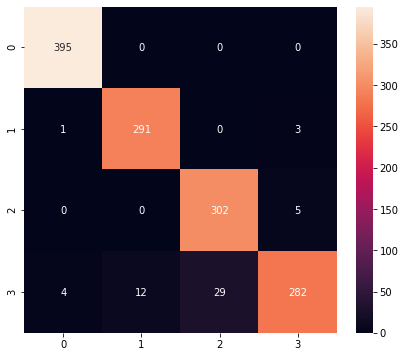

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.96      0.99      0.97       295
           2       0.91      0.98      0.95       307
           3       0.97      0.86      0.91       327

    accuracy                           0.96      1324
   macro avg       0.96      0.96      0.96      1324
weighted avg       0.96      0.96      0.96      1324



In [159]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# 转换为Tensorflow-Lite模型

In [160]:
# 保存为仅用于推理的模型
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [161]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [162]:
# 转换模型（量化）
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Van5SE\AppData\Local\Temp\tmpejtqtzbi\assets
INFO:tensorflow:Assets written to: C:\Users\Van5SE\AppData\Local\Temp\tmpejtqtzbi\assets


6304

# 推理测试

In [163]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [164]:
# 获取 输入输出 张量
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'input_8', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [165]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [166]:
%%time
# 推理执行
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 997 µs


In [167]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.9403664  0.01620508 0.01478212 0.02864632]
0
